In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D
from tqdm import tqdm

In [141]:
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

In [142]:
import torch.distributions as tdist

In [143]:
pointCount = 10
points = generateData.samplePoints(pointCount=pointCount).detach()

In [5]:
adjacent_points = []
for center_point in points:
    n = tdist.Normal(center_point, torch.tensor(0.1))
    adjacent_points.append( n.sample((3,)) )

adjacent_points = torch.cat(adjacent_points)

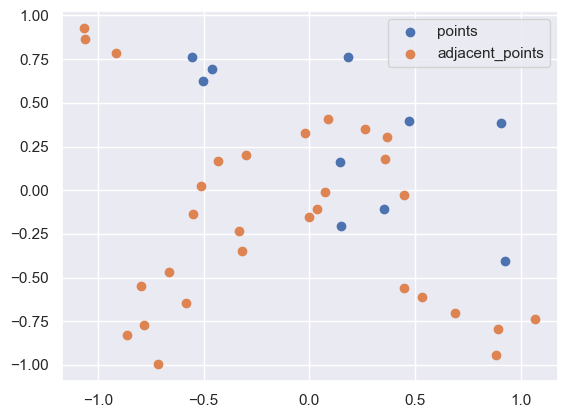

In [144]:
fig, ax = plt.subplots()
ax.scatter( points[:, 0], points[:, 1], label='points' )
ax.scatter( adjacent_points[:, 0], adjacent_points[:, 1], label='adjacent_points' )
ax.legend();

In [145]:
import networkx as nx

# Try the manifold regularisation without the data augmentation

In [146]:
# Build matrix of distances between particles
from turtle import distance
from scipy.spatial.distance import cdist
s = 0.5
distMatrix = cdist(points, points, lambda u, v: np.exp(-np.linalg.norm(u-v)**2 / s))
distMatrix.shape

(10, 10)

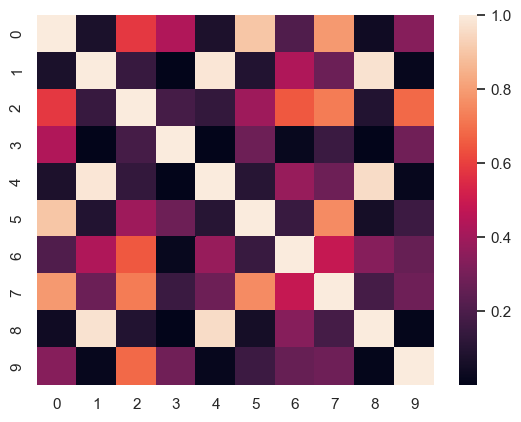

In [147]:
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(distMatrix)

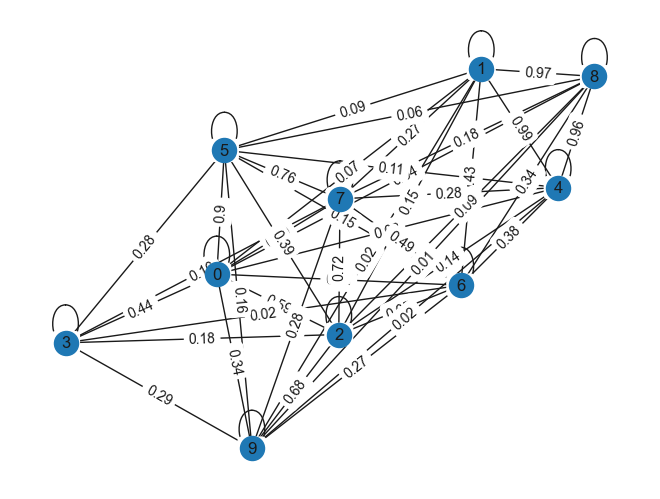

In [148]:
G = nx.Graph()
G = nx.from_numpy_matrix(np.round(distMatrix, 2), create_using=nx.Graph)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


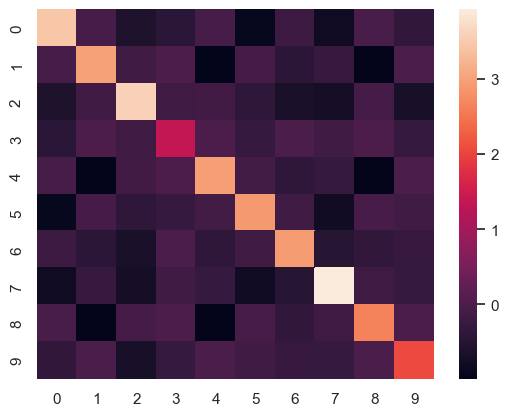

In [149]:
L = nx.laplacian_matrix(G)
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(L.toarray())

In [2]:
def computeLaplacianMatrix(points, s=1.):
    from turtle import distance
    from scipy.spatial.distance import cdist

    distMatrix = cdist(points, points, lambda u, v: np.exp(-np.linalg.norm(u-v)**2 / s))

    G = nx.from_numpy_matrix(distMatrix, create_using=nx.Graph)
    L = nx.laplacian_matrix(G)

    return L.toarray()

In [5]:
def computeDistanceMatrix(points, s=1.):
    from scipy.spatial.distance import cdist

    distMatrix = cdist(points, points, lambda u, v: np.exp(-np.linalg.norm(u-v)**2 / s))
    return distMatrix

In [152]:
xData = generateData.samplePoints(pointCount=10)
yData = torch.rand((10, 1))

In [153]:
computeLaplacianMatrix(xData.detach())

array([[ 4.08919875e+00, -4.13662321e-02, -4.27589736e-01,
        -4.19318618e-01, -9.65333509e-01, -1.22405957e-01,
        -1.40143254e-02, -4.93349744e-01, -6.71225495e-01,
        -9.34595130e-01],
       [-4.13662321e-02,  2.34602510e+00, -1.33943953e-01,
        -2.57952624e-01, -5.05112807e-02, -6.35030955e-01,
        -7.40327907e-01, -2.06773604e-01, -2.64313504e-01,
        -1.58050408e-02],
       [-4.27589736e-01, -1.33943953e-01,  2.61422019e+00,
        -1.91467956e-01, -5.74326743e-01, -1.14512482e-01,
        -1.20776438e-01, -2.02530680e-01, -5.77257359e-01,
        -2.71814841e-01],
       [-4.19318618e-01, -2.57952624e-01, -1.91467956e-01,
         4.02624615e+00, -3.69121529e-01, -6.99382227e-01,
        -7.03536971e-02, -9.88396113e-01, -7.40843163e-01,
        -2.89410228e-01],
       [-9.65333509e-01, -5.05112807e-02, -5.74326743e-01,
        -3.69121529e-01,  4.08077698e+00, -1.17694881e-01,
        -2.10208315e-02, -4.29799248e-01, -7.01173249e-01,
        -8.

In [184]:
distMatrix = computeDistanceMatrix(xData.detach())

In [185]:
( (yData - yData.T)**2 * torch.tensor(distMatrix).float() ).sum()

tensor(40.7499, grad_fn=<SumBackward0>)

In [178]:
from pde import NonLinear

layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)
gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':0}
lqr = NonLinear(network=network, gamma=gamma, correctShift=False)

gamma_adjacent = 1e-10
pointCount = 50
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

In [179]:
np.random.seed(0)
xData = generateData.samplePoints(pointCount=pointCount)
xEvaluation = generateData.sampleGrid(nPoint=100)

yTrue = lqr.dataValueFunction(xData.detach())

epochTotal = 0
info = []

# we compute the matrix based on the x's, en evaluate the loss with the y's
# laplacianMatrix = computeLaplacianMatrix(xData.detach())
distanceMatrix = computeDistanceMatrix(xData.detach())

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
        
    for epoch in range(iteration):
        yData = network.computeValueFunction(xData)
        
        # compute loss and backpropagate
        lossData = torch.mean( (yData.double() - yTrue.double())**2 ).float()

        lossAdjacent = ( ( yData - yData.T )**2 * torch.tensor(distanceMatrix).float() ).sum()

        loss = lossData + gamma_adjacent * lossAdjacent

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()

        epochTotal += 1
        info_dict = {
            'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.68e+00
100 / 3000 (100 / 1000), lr:1.0e-02, loss:6.09e-01
200 / 3000 (200 / 1000), lr:1.0e-02, loss:4.81e-01
300 / 3000 (300 / 1000), lr:1.0e-02, loss:1.86e-01
400 / 3000 (400 / 1000), lr:1.0e-02, loss:9.19e-02
500 / 3000 (500 / 1000), lr:1.0e-02, loss:5.30e-02
600 / 3000 (600 / 1000), lr:1.0e-02, loss:3.36e-02
700 / 3000 (700 / 1000), lr:1.0e-02, loss:2.27e-02
800 / 3000 (800 / 1000), lr:1.0e-02, loss:1.51e-02
900 / 3000 (900 / 1000), lr:1.0e-02, loss:9.37e-03
1000 / 3000 (0 / 2000), lr:1.0e-03, loss:5.68e-03
1100 / 3000 (100 / 2000), lr:1.0e-03, loss:3.98e-03
1200 / 3000 (200 / 2000), lr:1.0e-03, loss:2.86e-03
1300 / 3000 (300 / 2000), lr:1.0e-03, loss:2.13e-03
1400 / 3000 (400 / 2000), lr:1.0e-03, loss:1.62e-03
1500 / 3000 (500 / 2000), lr:1.0e-03, loss:1.25e-03
1600 / 3000 (600 / 2000), lr:1.0e-03, loss:9.71e-04
1700 / 3000 (700 / 2000), lr:1.0e-03, loss:7.50e-04
1800 / 3000 (800 / 2000), lr:1.0e-03, loss:5.80e-04
1900 / 3000 (900 / 2000), lr

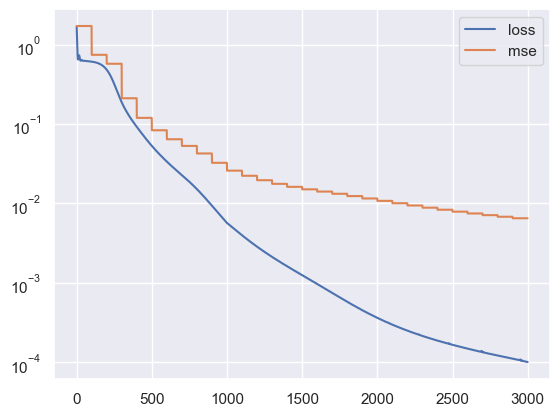

In [180]:
fig, ax = plt.subplots()
info['loss'].plot(ax=ax)
info['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

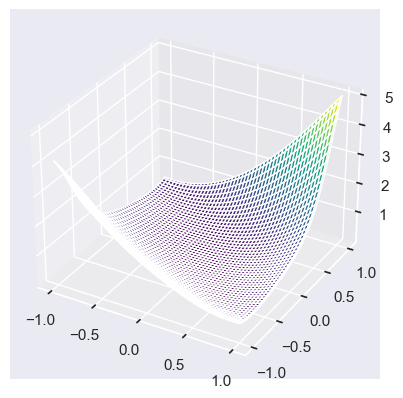

In [181]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Try the regularisation on the unsupervised version

In [186]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from pde import NonLinear

layers = [2, 20, 3]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False, imposePsd=True, spd=False, **{'spdPositive': 'Exp'})
gamma = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
lqr = NonLinear(network=network, gamma=gamma, correctShift=False)

manifold_reg = 1e-10
pointCount = 50
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

lrs = [1e-1, 1e-2]
iterations = [1000, 2000]

In [35]:
np.random.seed(0)
xData = generateData.samplePoints(pointCount=pointCount)
yTrue = lqr.dataValueFunction(xData.detach())

xInt = generateData.samplePoints(pointCount=pointCount)
xEvaluation = generateData.sampleGrid(nPoint=100)

epochTotal = 0
info = []

# we compute the matrix based on the x's, en evaluate the loss with the y's
# laplacianMatrix = computeLaplacianMatrix(xData.detach())
distanceMatrix = computeDistanceMatrix(xInt.detach(), s=0.1)

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
        
    for epoch in range(iteration):
        yData = network.computeValueFunction(xData)
        yInt = network.computeValueFunction(xInt)

        gradInt = network.computeValueFunctionDerivative(xInt)
        equation = lqr.computeHamiltonJacobiEquation(xInt, gradInt)
        lossResidual = torch.mean( equation**2 ).float()

        lossData = torch.mean( (yData.double() - yTrue.double())**2 ).float()

        reg = ( ( yInt - yInt.T )**2 * torch.tensor(distanceMatrix).float() ).sum()
        loss = 1*lossResidual + 0*lossData + manifold_reg * reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()

        epochTotal += 1
        info_dict = {
            #'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

0 / 3000 (0 / 1000), lr:1.0e-01, loss:8.96e-01
100 / 3000 (100 / 1000), lr:1.0e-01, loss:2.66e-03
200 / 3000 (200 / 1000), lr:1.0e-01, loss:9.67e-04
300 / 3000 (300 / 1000), lr:1.0e-01, loss:5.49e-04
400 / 3000 (400 / 1000), lr:1.0e-01, loss:3.78e-04
500 / 3000 (500 / 1000), lr:1.0e-01, loss:2.80e-04
600 / 3000 (600 / 1000), lr:1.0e-01, loss:2.09e-04
700 / 3000 (700 / 1000), lr:1.0e-01, loss:1.60e-04
800 / 3000 (800 / 1000), lr:1.0e-01, loss:1.28e-04
900 / 3000 (900 / 1000), lr:1.0e-01, loss:1.04e-04
1000 / 3000 (0 / 2000), lr:1.0e-02, loss:8.50e-05
1100 / 3000 (100 / 2000), lr:1.0e-02, loss:7.23e-05
1200 / 3000 (200 / 2000), lr:1.0e-02, loss:6.06e-05
1300 / 3000 (300 / 2000), lr:1.0e-02, loss:5.08e-05
1400 / 3000 (400 / 2000), lr:1.0e-02, loss:4.28e-05
1500 / 3000 (500 / 2000), lr:1.0e-02, loss:3.61e-05
1600 / 3000 (600 / 2000), lr:1.0e-02, loss:3.04e-05
1700 / 3000 (700 / 2000), lr:1.0e-02, loss:2.54e-05
1800 / 3000 (800 / 2000), lr:1.0e-02, loss:2.10e-05
1900 / 3000 (900 / 2000), lr

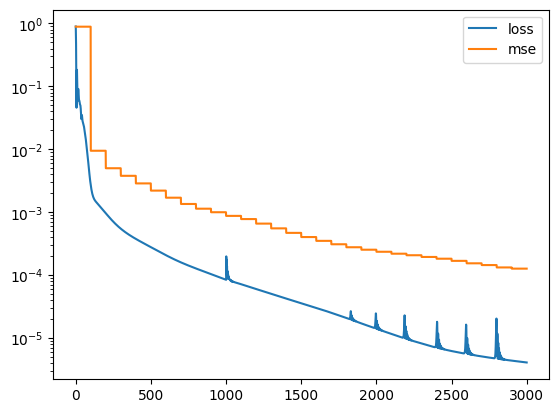

In [36]:
fig, ax = plt.subplots()
info['loss'].plot(ax=ax)
info['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

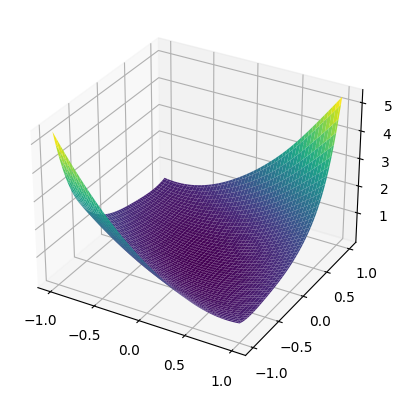

In [37]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [9]:
distanceMatrix = computeDistanceMatrix(xInt.detach(), s=0.2)

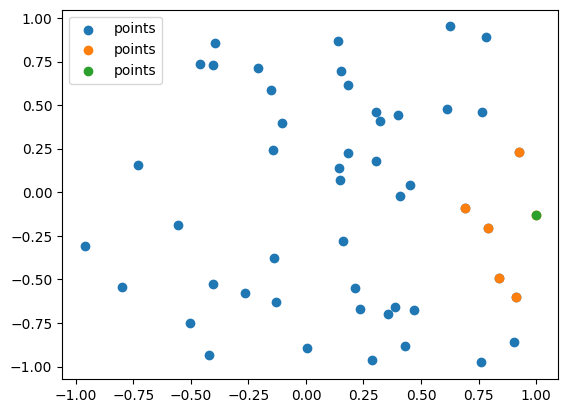

In [12]:
fig, ax = plt.subplots()
ax.scatter( xInt[:-1, 0].detach(), xInt[:-1, 1].detach(), label='points' )


closePoints = xInt[np.where( distanceMatrix[-1] > 0.3 )[0]]
ax.scatter( closePoints[:, 0].detach(), closePoints[:, 1].detach(), label='points' )
ax.scatter( xInt[-1, 0].detach(), xInt[-1, 1].detach(), label='points' )
ax.legend();

In [142]:
( yInt - yInt.T )#**2 * torch.tensor(distanceMatrix).float() ).sum()

tensor([[ 0.0000, -0.0257,  0.0051,  ..., -0.0042, -0.1262, -0.0048],
        [ 0.0257,  0.0000,  0.0307,  ...,  0.0215, -0.1006,  0.0208],
        [-0.0051, -0.0307,  0.0000,  ..., -0.0093, -0.1313, -0.0099],
        ...,
        [ 0.0042, -0.0215,  0.0093,  ...,  0.0000, -0.1220, -0.0006],
        [ 0.1262,  0.1006,  0.1313,  ...,  0.1220,  0.0000,  0.1214],
        [ 0.0048, -0.0208,  0.0099,  ...,  0.0006, -0.1214,  0.0000]],
       grad_fn=<SubBackward0>)

# Example with real Neural network

In [ ]:
# Build matrix of distances between particles
from scipy.spatial.distance import cdist
distMatrix = cdist(points, adjacent_points)
distMatrix

array([[0.05627963, 0.09952351, 0.03967517, 1.53512093, 1.48263419,
        1.50503366, 1.64191144, 1.58252672, 1.64415294, 1.51458472,
        1.57569148, 1.49217686, 0.54660167, 0.4451399 , 0.58069233,
        1.5313734 , 1.36384446, 1.13514976, 1.71962093, 1.74922467,
        1.77889194, 2.18402456, 2.24947107, 2.09739566, 1.66891701,
        1.92691918, 1.72112614, 1.76791579, 1.98381727, 1.81966173],
       [1.4745016 , 1.34148993, 1.45680102, 0.09487681, 0.05466074,
        0.1016771 , 1.83382551, 1.84862674, 1.70257363, 2.1690485 ,
        2.26360105, 2.09824467, 1.335274  , 1.21397697, 1.53272556,
        1.97308229, 1.88345367, 1.72949492, 1.24963123, 1.04704727,
        1.20846415, 1.77727221, 1.72089438, 1.65025734, 1.64401281,
        2.02799336, 1.85824748, 1.07145722, 1.11421021, 1.06099917],
       [1.69347239, 1.60083508, 1.61069197, 1.8577092 , 1.86289854,
        1.91212463, 0.02836889, 0.11486297, 0.14541572, 0.63339837,
        0.71162941, 0.55401478, 1.09503776, 1.

In [ ]:
# we may want to use a threshold on the distance too? Or maybe just sample closer to each point..
(( distMatrix < 0.5 ) * 1 ).sum()

116

In [42]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)
gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

gamma_adjacent = 0*1e-1
pointCount = 11
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

lrs = [1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 4000]

In [213]:
np.random.seed(0)
xData = generateData.samplePoints(pointCount=pointCount)
xAdjacentData = generateData.samplePoints(pointCount=pointCount)
xEvaluation = generateData.sampleGrid(nPoint=100)

yTrue = lqr.dataValueFunction(xData.detach())

epochTotal = 0
info = []


# we compute the matrix based on the x's, en evaluate the loss with the y's
distMatrix = cdist(xData.detach().numpy(), xAdjacentData.detach().numpy())

# take the inverse of the distance
# distMatrix = 1. / distMatrix

# or apply a threshold
distMatrix = ( distMatrix < 0.2 ) * 1
print(distMatrix.sum())

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
        
    for epoch in range(iteration):
        yData = network.computeValueFunction(xData)
        yAdjacentData = network.computeValueFunction(xAdjacentData)
        
        # compute loss and backpropagate
        lossData = torch.mean( (yData.double() - yTrue.double())**2 ).float()

        lossAdjacent = ( ( yData - yAdjacentData.T )**2 * torch.tensor(distMatrix).float() ).sum()

        loss = lossData + gamma_adjacent * lossAdjacent

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()


        epochTotal += 1
        info_dict = {
            'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

5
0 / 7000 (0 / 1000), lr:1.0e-02, loss:1.87e-02
100 / 7000 (100 / 1000), lr:1.0e-02, loss:1.38e-02
200 / 7000 (200 / 1000), lr:1.0e-02, loss:1.36e-02
300 / 7000 (300 / 1000), lr:1.0e-02, loss:1.08e-02
400 / 7000 (400 / 1000), lr:1.0e-02, loss:9.60e-04
500 / 7000 (500 / 1000), lr:1.0e-02, loss:8.78e-04
600 / 7000 (600 / 1000), lr:1.0e-02, loss:8.08e-04
700 / 7000 (700 / 1000), lr:1.0e-02, loss:6.93e-04
800 / 7000 (800 / 1000), lr:1.0e-02, loss:5.10e-04
900 / 7000 (900 / 1000), lr:1.0e-02, loss:2.94e-04
1000 / 7000 (0 / 2000), lr:1.0e-03, loss:1.39e-04
1100 / 7000 (100 / 2000), lr:1.0e-03, loss:1.20e-04
1200 / 7000 (200 / 2000), lr:1.0e-03, loss:9.83e-05
1300 / 7000 (300 / 2000), lr:1.0e-03, loss:8.09e-05
1400 / 7000 (400 / 2000), lr:1.0e-03, loss:6.81e-05
1500 / 7000 (500 / 2000), lr:1.0e-03, loss:5.85e-05
1600 / 7000 (600 / 2000), lr:1.0e-03, loss:5.10e-05
1700 / 7000 (700 / 2000), lr:1.0e-03, loss:4.47e-05
1800 / 7000 (800 / 2000), lr:1.0e-03, loss:3.93e-05
1900 / 7000 (900 / 2000), 

In [214]:
xData[:2]

tensor([[0.0976, 0.0578],
        [0.4304, 0.1361]], grad_fn=<SliceBackward>)

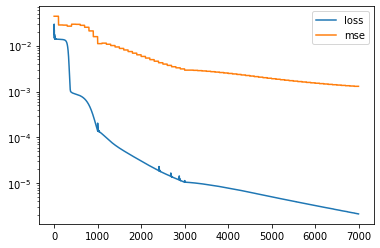

In [215]:
fig, ax = plt.subplots()
info['loss'].plot(ax=ax)
info['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

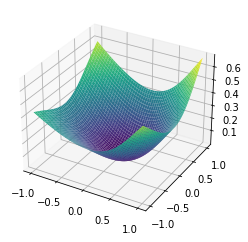

In [216]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Reference

In [233]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)

gamma = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

In [234]:
lrs = [1e-1, 1e-2]
iterations = [500, 1000]

resu = lqr.train(interiorPointCount=100, dataPointCount=1, lrs=lrs, iterations=iterations, useTestData=False, verbose=True)

xInt:  torch.Size([100, 2])
xData:  torch.Size([1, 2])
0 / 1500 (0 / 500), lr:1.0e-01, loss:1.27e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.27e-01, mat: 0.00e+00)
100 / 1500 (100 / 500), lr:1.0e-01, loss:3.23e-02 (data: 0.00e+00, grad: 0.00e+00, res: 3.23e-02, mat: 0.00e+00)
200 / 1500 (200 / 500), lr:1.0e-01, loss:1.47e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.47e-03, mat: 0.00e+00)
300 / 1500 (300 / 500), lr:1.0e-01, loss:4.69e-04 (data: 0.00e+00, grad: 0.00e+00, res: 4.69e-04, mat: 0.00e+00)
400 / 1500 (400 / 500), lr:1.0e-01, loss:3.38e-04 (data: 0.00e+00, grad: 0.00e+00, res: 3.38e-04, mat: 0.00e+00)
500 / 1500 (0 / 1000), lr:1.0e-02, loss:6.45e-05 (data: 0.00e+00, grad: 0.00e+00, res: 6.45e-05, mat: 0.00e+00)
600 / 1500 (100 / 1000), lr:1.0e-02, loss:3.83e-05 (data: 0.00e+00, grad: 0.00e+00, res: 3.83e-05, mat: 0.00e+00)
700 / 1500 (200 / 1000), lr:1.0e-02, loss:2.85e-05 (data: 0.00e+00, grad: 0.00e+00, res: 2.85e-05, mat: 0.00e+00)
800 / 1500 (300 / 1000), lr:1.0e-02, loss:1.

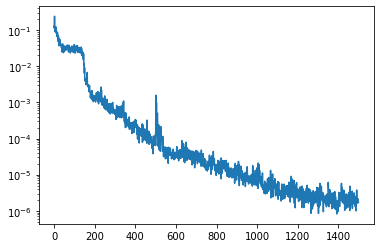

In [235]:
plt.plot( resu['loss'] )
plt.yscale('log')

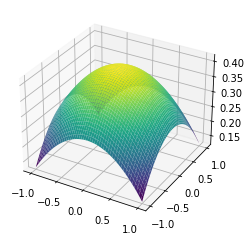

In [236]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = lqr.network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');